# Import Dependencies

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import ConcatDataset
from torch.cuda.amp import autocast
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Data Preparation

In [2]:
data_dir = r'/kaggle/input/seendatasets/Seen Datasets/train'
classes = os.listdir(data_dir)
print(classes)

['Common-Rosefinch', 'Asian-Green-Bee-Eater', 'Common-Kingfisher', 'Jungle-Babbler', 'White-Wagtail', 'Indian-Roller', 'Brown-Headed-Barbet', 'Common-Tailorbird', 'Rufous-Treepie', 'White-Breasted-Waterhen', 'Forest-Wagtail', 'Common-Myna', 'Sarus-Crane', 'House-Crow', 'Hoopoe', 'Coppersmith-Barbet', 'Cattle-Egret', 'Indian-Peacock', 'White-Breasted-Kingfisher', 'Gray-Wagtail', 'Ruddy-Shelduck', 'Red-Wattled-Lapwing', 'Indian-Pitta', 'Indian-Grey-Hornbill', 'Northern-Lapwing']


In [3]:
image_size=(416,416)
batch_size= 32

## Mean and Std Claculation

In [4]:
# dataset1 = ImageFolder(data_dir, transform=tt.Compose([
#                                         tt.Resize(image_size),
#                                         tt.ToTensor()]))
# dataset2 = ImageFolder(r'/kaggle/input/seendatasets/Seen Datasets/val', transform=tt.Compose([
#                                         tt.Resize(image_size),
#                                         tt.ToTensor()]))
# dataset = ConcatDataset([dataset1,dataset2])
# dataset_dl = DataLoader(dataset, batch_size, shuffle=True)

# def get_mean_and_std(dataloader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in tqdm(dataloader):

#         channels_sum += torch.mean(data, dim=[0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#         num_batches += 1

#     mean = channels_sum / num_batches

#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

#     return mean, std

# mean, std = get_mean_and_std(dataset_dl)

mean=[0.4724, 0.4814, 0.4018]
std=[0.2450, 0.2429, 0.2691]

## Data Augmentation

In [5]:
train_tfms = tt.Compose([tt.RandomHorizontalFlip(),
                        tt.RandomRotation(5),
                        tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                        tt.RandomErasing(p=0.2)
                        ])

In [6]:
transformations_to_perform = transform=tt.Compose([
                                tt.Resize(image_size),
                                tt.ToTensor(),
                                tt.Normalize(mean, std)])

train_ds = ImageFolder(data_dir, transformations_to_perform)
valid_ds = ImageFolder(r'/kaggle/input/seendatasets/Seen Datasets/val',transformations_to_perform)

## Data Loader

In [7]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=0, pin_memory=True)

In [8]:
train_dl.transforms = train_tfms

## Batch Visualisation

In [9]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, mean,std)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

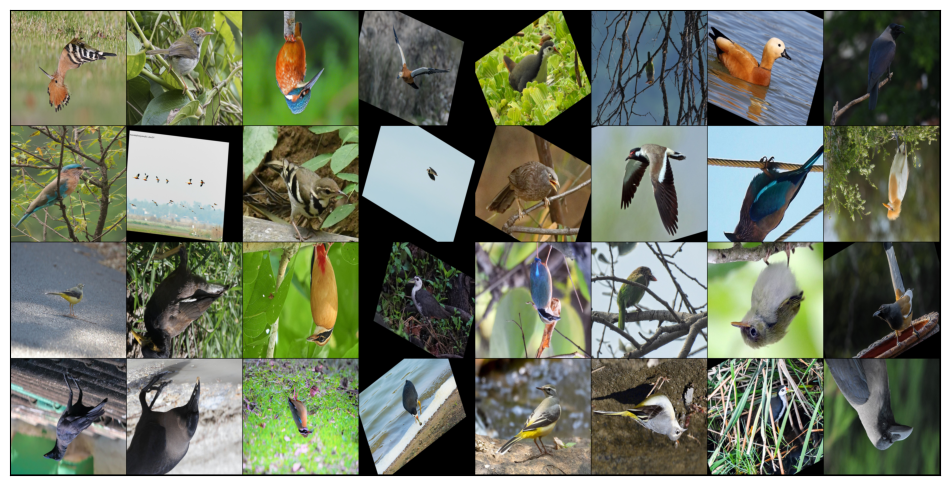

In [10]:
show_batch(train_dl)

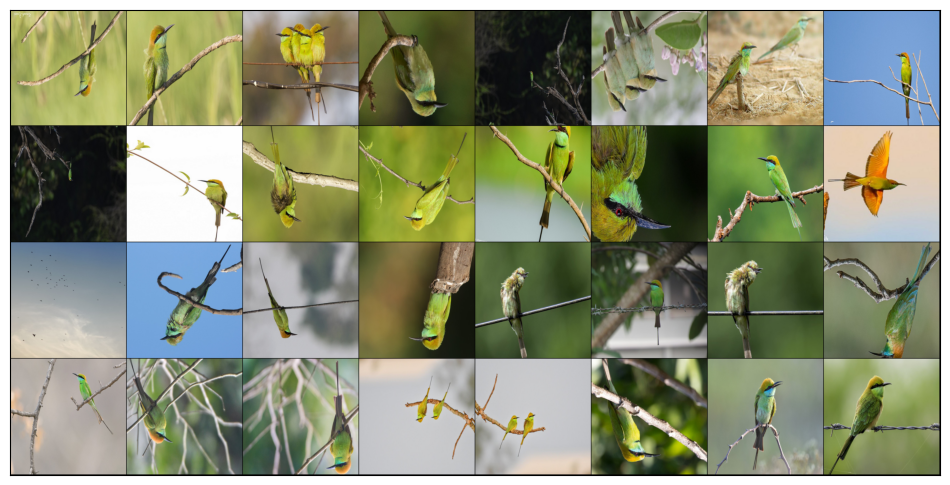

In [11]:
show_batch(valid_dl)

## Device Selection

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model Building

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out,labels)          # Calculate accuracy
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f},train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'],result['train_acc'], result['val_loss'], result['val_acc']))

In [16]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU6(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU6(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class ResNet9(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        # 3 * 416 * 416
        self.conv1 = ConvBlock(3, 64, kernel_size=3, stride=2, padding=1)
        # 64 * 416 * 416
        self.conv2 = DepthwiseSeparableConv(64, 128, stride=2)
        # 128 * 208 * 208
        self.res1 = nn.Sequential(DepthwiseSeparableConv(128, 128), DepthwiseSeparableConv(128, 128))
        # 128 * 208 * 208
        self.conv3 = DepthwiseSeparableConv(128, 256, stride=2)
        # 256 * 104 * 104
        self.conv4 = DepthwiseSeparableConv(256, 512, stride=2)
        # 512 * 52 * 52
        self.res2 = nn.Sequential(DepthwiseSeparableConv(512, 512), DepthwiseSeparableConv(512, 512))
        # 512 * 52 * 52
        self.conv5 = DepthwiseSeparableConv(512,1024, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(nn.Dropout(0.2),
                                        nn.Linear(1024, num_classes))

        
    def forward(self, xb):
        with autocast():
            out = self.conv1(xb)
            out = self.conv2(out)
            out = self.res1(out) + out
            out = self.conv3(out)
            out = self.conv4(out)
            out = self.res2(out) + out
            out = self.conv5(out)
            out = self.avgpool(out)
            out = torch.flatten(out,1)
            out = self.classifier(out)
        return out

In [17]:
model = to_device(ResNet9(25), device)
model

ResNet9(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU6(inplace=True)
  )
  (conv2): DepthwiseSeparableConv(
    (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU6(inplace=True)
  )
  (res1): Sequential(
    (0): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
    )
    (1): DepthwiseSepara

## Training Model

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def modeltrain(epochs, lr, model, train_loader, val_loader, 
                  weight_decay=0,grad_clip=None, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    scheduler = OneCycleLR(optimizer, max_lr=lr, epochs=epochs, steps_per_epoch=len(train_loader))
    torch.cuda.empty_cache()
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []
        lrs = []
        
        for batch in tqdm(train_loader):
            batch = to_device(batch,device)
            loss,acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            loss.backward()
            
            
            if grad_clip: 
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            scheduler.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs

        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.21875, 'val_acc': 0.03989361599087715}]

In [20]:
epochs = 50
lr = 0.01
weight_decay = 1e-4
grad_clip = 0.1
opt_func = torch.optim.Adam

In [21]:
%%time
history += modeltrain(epochs, lr, model, train_dl, valid_dl,  
                            weight_decay=weight_decay, 
                            grad_clip = grad_clip,
                            opt_func=opt_func)

100%|██████████| 704/704 [09:00<00:00,  1.30it/s]


Epoch [0], train_loss: 2.3555,train_acc: 0.2759, val_loss: 1.9971, val_acc: 0.3754


100%|██████████| 704/704 [06:44<00:00,  1.74it/s]


Epoch [1], train_loss: 1.6885,train_acc: 0.4705, val_loss: 1.4619, val_acc: 0.5427


100%|██████████| 704/704 [06:37<00:00,  1.77it/s]


Epoch [2], train_loss: 1.2871,train_acc: 0.5959, val_loss: 1.2256, val_acc: 0.6238


100%|██████████| 704/704 [06:41<00:00,  1.75it/s]


Epoch [3], train_loss: 1.0469,train_acc: 0.6780, val_loss: 1.5195, val_acc: 0.6064


100%|██████████| 704/704 [06:45<00:00,  1.74it/s]


Epoch [4], train_loss: 0.9141,train_acc: 0.7260, val_loss: 1.2422, val_acc: 0.6462


100%|██████████| 704/704 [06:41<00:00,  1.75it/s]


Epoch [5], train_loss: 0.8032,train_acc: 0.7577, val_loss: 1.1572, val_acc: 0.6941


100%|██████████| 704/704 [06:42<00:00,  1.75it/s]


Epoch [6], train_loss: 0.7427,train_acc: 0.7798, val_loss: 0.9492, val_acc: 0.7175


100%|██████████| 704/704 [06:40<00:00,  1.76it/s]


Epoch [7], train_loss: 0.6865,train_acc: 0.7960, val_loss: 1.2988, val_acc: 0.6695


100%|██████████| 704/704 [06:35<00:00,  1.78it/s]


Epoch [8], train_loss: 0.6885,train_acc: 0.7959, val_loss: 1.3662, val_acc: 0.6655


100%|██████████| 704/704 [06:43<00:00,  1.75it/s]


Epoch [9], train_loss: 0.6694,train_acc: 0.7990, val_loss: 1.2041, val_acc: 0.6859


100%|██████████| 704/704 [06:32<00:00,  1.79it/s]


Epoch [10], train_loss: 0.6504,train_acc: 0.8049, val_loss: 1.0762, val_acc: 0.6957


100%|██████████| 704/704 [06:34<00:00,  1.79it/s]


Epoch [11], train_loss: 0.6548,train_acc: 0.8044, val_loss: 1.2373, val_acc: 0.7161


100%|██████████| 704/704 [06:31<00:00,  1.80it/s]


Epoch [12], train_loss: 0.6455,train_acc: 0.8074, val_loss: 0.8579, val_acc: 0.7575


100%|██████████| 704/704 [06:37<00:00,  1.77it/s]


Epoch [13], train_loss: 0.6436,train_acc: 0.8097, val_loss: 0.9121, val_acc: 0.7484


100%|██████████| 704/704 [06:42<00:00,  1.75it/s]


Epoch [14], train_loss: 0.6328,train_acc: 0.8147, val_loss: 0.9326, val_acc: 0.7520


100%|██████████| 704/704 [06:35<00:00,  1.78it/s]


Epoch [15], train_loss: 0.5986,train_acc: 0.8214, val_loss: 1.2988, val_acc: 0.6887


100%|██████████| 704/704 [06:29<00:00,  1.81it/s]


Epoch [16], train_loss: 0.5879,train_acc: 0.8251, val_loss: 0.6655, val_acc: 0.8008


100%|██████████| 704/704 [06:32<00:00,  1.79it/s]


Epoch [17], train_loss: 0.5679,train_acc: 0.8322, val_loss: 0.6411, val_acc: 0.8131


100%|██████████| 704/704 [06:33<00:00,  1.79it/s]


Epoch [18], train_loss: 0.5684,train_acc: 0.8326, val_loss: 0.6514, val_acc: 0.8076


100%|██████████| 704/704 [06:33<00:00,  1.79it/s]


Epoch [19], train_loss: 0.5459,train_acc: 0.8402, val_loss: 0.9141, val_acc: 0.7754


100%|██████████| 704/704 [06:40<00:00,  1.76it/s]


Epoch [20], train_loss: 0.5376,train_acc: 0.8404, val_loss: 0.6772, val_acc: 0.8046


100%|██████████| 704/704 [06:42<00:00,  1.75it/s]


Epoch [21], train_loss: 0.5205,train_acc: 0.8478, val_loss: 0.8398, val_acc: 0.7719


100%|██████████| 704/704 [06:43<00:00,  1.75it/s]


Epoch [22], train_loss: 0.5020,train_acc: 0.8500, val_loss: 0.6299, val_acc: 0.8162


100%|██████████| 704/704 [06:41<00:00,  1.75it/s]


Epoch [23], train_loss: 0.4875,train_acc: 0.8546, val_loss: 0.5488, val_acc: 0.8423


100%|██████████| 704/704 [06:33<00:00,  1.79it/s]


Epoch [24], train_loss: 0.4661,train_acc: 0.8615, val_loss: 0.6670, val_acc: 0.8083


100%|██████████| 704/704 [06:28<00:00,  1.81it/s]


Epoch [25], train_loss: 0.4595,train_acc: 0.8641, val_loss: 0.7769, val_acc: 0.7932


100%|██████████| 704/704 [06:39<00:00,  1.76it/s]


Epoch [26], train_loss: 0.4243,train_acc: 0.8758, val_loss: 0.5127, val_acc: 0.8507


100%|██████████| 704/704 [06:35<00:00,  1.78it/s]


Epoch [27], train_loss: 0.4229,train_acc: 0.8752, val_loss: 0.5693, val_acc: 0.8336


100%|██████████| 704/704 [06:37<00:00,  1.77it/s]


Epoch [28], train_loss: 0.4041,train_acc: 0.8820, val_loss: 0.4846, val_acc: 0.8490


100%|██████████| 704/704 [06:40<00:00,  1.76it/s]


Epoch [29], train_loss: 0.3679,train_acc: 0.8900, val_loss: 0.5054, val_acc: 0.8539


100%|██████████| 704/704 [06:37<00:00,  1.77it/s]


Epoch [30], train_loss: 0.3542,train_acc: 0.8949, val_loss: 0.5439, val_acc: 0.8528


100%|██████████| 704/704 [06:34<00:00,  1.79it/s]


Epoch [31], train_loss: 0.3481,train_acc: 0.8952, val_loss: 0.5869, val_acc: 0.8387


100%|██████████| 704/704 [06:32<00:00,  1.79it/s]


Epoch [32], train_loss: 0.3228,train_acc: 0.9052, val_loss: 0.4849, val_acc: 0.8602


100%|██████████| 704/704 [06:43<00:00,  1.75it/s]


Epoch [33], train_loss: 0.3018,train_acc: 0.9104, val_loss: 0.4241, val_acc: 0.8791


100%|██████████| 704/704 [06:42<00:00,  1.75it/s]


Epoch [34], train_loss: 0.2651,train_acc: 0.9215, val_loss: 0.3574, val_acc: 0.8948


100%|██████████| 704/704 [06:40<00:00,  1.76it/s]


Epoch [35], train_loss: 0.2556,train_acc: 0.9232, val_loss: 0.4392, val_acc: 0.8781


100%|██████████| 704/704 [06:38<00:00,  1.77it/s]


Epoch [36], train_loss: 0.2279,train_acc: 0.9320, val_loss: 0.4163, val_acc: 0.8836


100%|██████████| 704/704 [06:46<00:00,  1.73it/s]


Epoch [37], train_loss: 0.1979,train_acc: 0.9399, val_loss: 0.3628, val_acc: 0.8943


100%|██████████| 704/704 [06:34<00:00,  1.78it/s]


Epoch [38], train_loss: 0.1849,train_acc: 0.9450, val_loss: 0.3618, val_acc: 0.8966


100%|██████████| 704/704 [06:33<00:00,  1.79it/s]


Epoch [39], train_loss: 0.1570,train_acc: 0.9556, val_loss: 0.3086, val_acc: 0.9099


100%|██████████| 704/704 [06:39<00:00,  1.76it/s]


Epoch [40], train_loss: 0.1390,train_acc: 0.9598, val_loss: 0.2732, val_acc: 0.9186


100%|██████████| 704/704 [06:54<00:00,  1.70it/s]


Epoch [41], train_loss: 0.1139,train_acc: 0.9677, val_loss: 0.2710, val_acc: 0.9208


100%|██████████| 704/704 [06:48<00:00,  1.73it/s]


Epoch [42], train_loss: 0.0979,train_acc: 0.9734, val_loss: 0.2664, val_acc: 0.9244


100%|██████████| 704/704 [06:47<00:00,  1.73it/s]


Epoch [43], train_loss: 0.0856,train_acc: 0.9771, val_loss: 0.2607, val_acc: 0.9263


100%|██████████| 704/704 [06:48<00:00,  1.72it/s]


Epoch [44], train_loss: 0.0826,train_acc: 0.9797, val_loss: 0.2563, val_acc: 0.9273


100%|██████████| 704/704 [06:39<00:00,  1.76it/s]


Epoch [45], train_loss: 0.0645,train_acc: 0.9840, val_loss: 0.2430, val_acc: 0.9289


100%|██████████| 704/704 [06:34<00:00,  1.78it/s]


Epoch [46], train_loss: 0.0599,train_acc: 0.9874, val_loss: 0.2458, val_acc: 0.9317


100%|██████████| 704/704 [06:36<00:00,  1.78it/s]


Epoch [47], train_loss: 0.0552,train_acc: 0.9889, val_loss: 0.2451, val_acc: 0.9307


100%|██████████| 704/704 [06:35<00:00,  1.78it/s]


Epoch [48], train_loss: 0.0504,train_acc: 0.9901, val_loss: 0.2534, val_acc: 0.9296


100%|██████████| 704/704 [06:43<00:00,  1.74it/s]


Epoch [49], train_loss: 0.0485,train_acc: 0.9905, val_loss: 0.2472, val_acc: 0.9296
CPU times: user 13h 3min 12s, sys: 4min 58s, total: 13h 8min 11s
Wall time: 7h 22min


## Saving Model

In [22]:
torch.save(model,'model.pth')

In [23]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt')

## Plotting Metrics

In [24]:
def plot_accuracies(history):
    train_accs =[x.get('train_acc') for x in history]
    val_accs = [x['val_acc'] for x in history]
    plt.plot(train_accs,'-b')
    plt.plot(val_accs, '-r')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('accuracy.png');

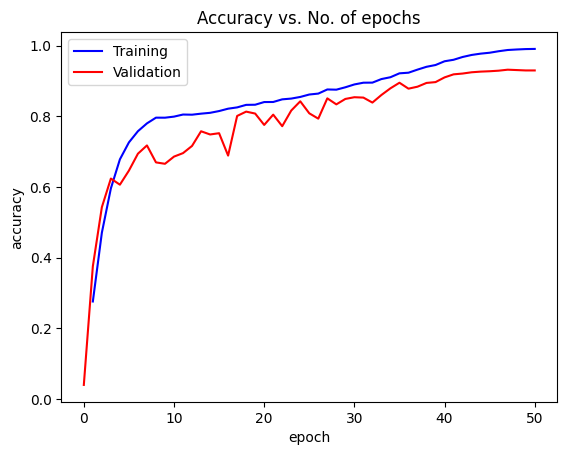

In [25]:
plot_accuracies(history)

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig('losses.png');

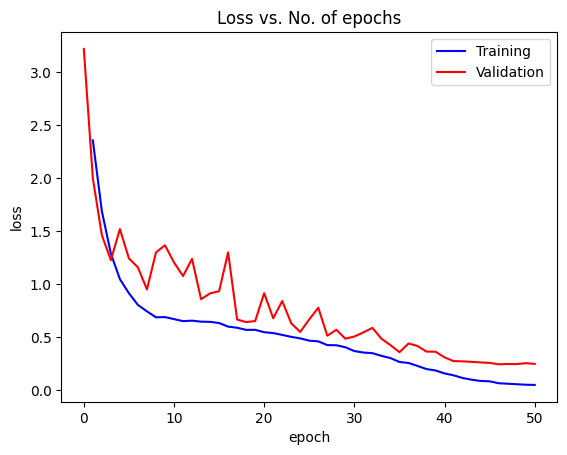

In [27]:
plot_losses(history)

In [28]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig('lrs.png');

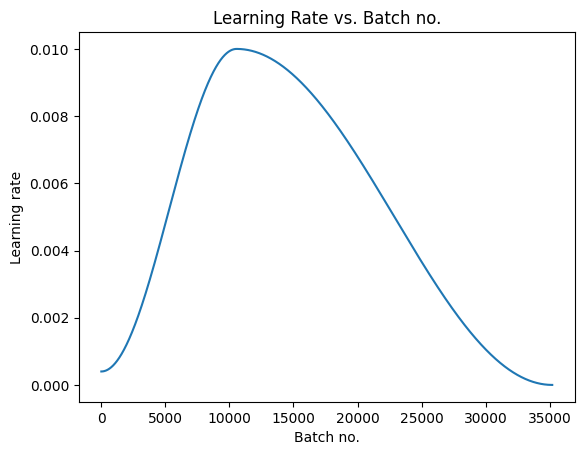

In [29]:
plot_lrs(history)